# Deterministic Optimization Model - Bus Charging Scheduling

## Initialization

In [76]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [77]:
EXEC_PATH = '/Applications/CPLEX_Studio221/cplex/bin/x86-64_osx/cplex'
#EXEC_PATH = '/home/jonatas.manzolli/Documents/opt/ibm/CPLEX_Studio201/cplex/bin/x86-64_linux/cplex'

In [78]:
model = pyo.ConcreteModel()

## Data

In [79]:
data = pd.read_excel('../Instances/input_small.xlsx', None)

i = len(data['Trip time']['Time begin (min)'])
t = len(data['Energy price']['Energy buying price (per minute)'])
k = len(data['Buses']['Bus (kWh)'])
n = len(data['Chargers']['Charger (kWh/min)'])
l = len(data['Power price']['Power'])

T_start = data['Trip time']['Time begin (min)'].tolist()
T_start = [int(x) for x in T_start]
T_end = data['Trip time']['Time finish (min)'].tolist()
T_end = [int(x) for x in T_end]

alpha = data['Chargers']['Charger (kWh/min)'].tolist()
beta = data['Chargers']['Charger (kWh/min)'].tolist()
ch_eff = 0.90
dch_eff = 1/0.9
gama = data['Energy consumption']['Uncertain energy (kWh/km*min)'].tolist()

P = data['Energy price']['Energy buying price (per minute)'].tolist()
S = data['Energy price']['Energy selling price (per minute)'].tolist()

E_0 = 0.2
E_min = 0.2
E_max = 1
E_end = 0.2
C_bat = data['Buses']['Bus (kWh)'].tolist()
d = 10 # mininum charging step

U_pow = data['Power price']['Power'].tolist()
U_price = data['Power price']['Price'].tolist()
U_max = data['Chargers']['Max Power (kW)'].tolist()

R = 130
Ah = 905452
V = 512
T = len(data['Energy price']['Energy buying price (per minute)'])

## Sets

In [80]:
model.I = pyo.RangeSet(i) # set of trips
model.T = pyo.RangeSet(t) # set of timesteps
model.K = pyo.RangeSet(k) # set of buses
model.N = pyo.RangeSet(n) # set of chargers
model.L = pyo.RangeSet(l) # set of peak power levels

## Parameters

In [81]:
model.T_start = pyo.Param(model.I, initialize=lambda model, i: T_start[i-1]) # start time of trip i
model.T_end = pyo.Param(model.I, initialize=lambda model, i: T_end[i-1]) # end time of trip i

model.alpha = pyo.Param(model.N, initialize=lambda model, n: alpha[n-1]) # charging power of charger n
model.beta = pyo.Param(model.N, initialize=lambda model, n: beta[n-1]) # discharging power of charger n

model.ch_eff = pyo.Param(initialize=ch_eff) # charging efficiency of charger n
model.dch_eff = pyo.Param(initialize=dch_eff) # discharging efficiency of charger n
model.gama = pyo.Param(model.I, initialize=lambda model, i: gama[i-1]) # energy consumption

model.P = pyo.Param(model.T, initialize=lambda model, t: P[t-1]) # electricity purchasing price in time t
model.S = pyo.Param(model.T, initialize=lambda model, t: S[t-1]) # electricity selling price in time t

model.E_0 = pyo.Param(initialize=E_0) # initial energy level of bus k
model.E_min = pyo.Param(initialize=E_min) # minimum energy level allowed for bus k
model.E_max = pyo.Param(initialize=E_max) # maximum energy level allowed for bus k
model.E_end = pyo.Param(initialize=E_end) # minimum energy after an operation day for bus k
model.C_bat = pyo.Param(model.K, initialize=lambda model, k: C_bat[k-1]) # total capacity of the bus k battery

model.U_pow = pyo.Param(model.L, initialize=lambda model, l: U_pow[l-1]) # power level l
model.U_price = pyo.Param(model.L, initialize=lambda model, l: U_price[l-1]) # purchasing price for power level l
model.U_max = pyo.Param(initialize=U_max[0]) # contracted power

model.R = pyo.Param(initialize=R) # battery replacement costs of the bus k
model.Ah = pyo.Param(initialize=Ah) # energy consumed until EOL of bus k
model.V = pyo.Param(initialize=V) # operational voltage of charger n

## Decision Variables

In [82]:
#binary variables

# binary variable indicating if bus k is serving trip i at time t
model.b = pyo.Var(model.K,model.I, model.T, within=pyo.Binary)

# binary variable indicating if bus k is occupying a charger n at time t to charge
model.x = pyo.Var(model.K, model.N, model.T, domain=pyo.Binary)

# binary variable indicating if bus k is occupying a charger n at time t to discharge
model.y = pyo.Var(model.K, model.N, model.T, domain=pyo.Binary)

# binary variable indicating if bus k is charging/discharging at time t
model.c = pyo.Var(model.K, model.T, domain=pyo.Binary)

# binary variable indicating the peak power level l
model.u = pyo.Var(model.L, domain=pyo.Binary)

#non-negative variables

# energy level of bus k at time t
model.e = pyo.Var(model.K, model.T, within=pyo.NonNegativeReals) 

# electricity purchased from the grid at time t
model.w_buy = pyo.Var(model.T, within=pyo.NonNegativeReals)

# electricity sold to the grid at time t
model.w_sell = pyo.Var(model.T, within=pyo.NonNegativeReals)

# total degradation cost of the bus k battery at time t
model.d = pyo.Var(model.K, model.T, within=pyo.NonNegativeReals)

model.delta_t = pyo.Var(within = pyo.PositiveIntegers)

## Objective Function

In [83]:
def rule_obj(mod):
    return sum(mod.P[t]*mod.w_buy[t] for t in mod.T) - sum(mod.S[t]*mod.w_sell[t] for t in mod.T) + sum(mod.d[k,t] for k in mod.K for t in mod.T) + sum(mod.U_price[l]*mod.u[l] for l in mod.L)
model.obj = pyo.Objective(rule=rule_obj, sense=pyo.minimize)

## Constraints

In [84]:
model.constraints = pyo.ConstraintList()  # Create a set of constraints


####### RESOLVER O PROBLEMA DO CARREGAMENTO INTERMITENTE. COLOCAR UMA VARIÁVEL PARA UM TEMPO MÍNIMO DE CARREGAMENTO!
# for k in model.K:
#     for n in model.N:
#         for t in range(2,T-d+1):
#             model.constraints.add(1 - model.x[k,n,t] + model.x[k,n,t-1]  + ((1/d)*sum(model.x[k,n,j] for j in range(t,t+d-1))) <= 2) # 33

for k in model.K:
    for n in model.N:
        for t in range(2,T-d+1):
            model.constraints.add(1 - model.x[k,n,t] + model.x[k,n,t-1] + ((1/d)*sum(model.x[k,n,j] for j in range(t,t+d-1))) >= 1) # 34

# for k in model.K:
#     for n in model.N:
#         for t in range(T-d+2,T):
#             model.constraints.add(1 - model.x[k,n,t] + model.x[k,n,t-1] + ((1/(T-t+1))*sum(model.x[k,n,j] for j in range(t,T))) <= 2) # 35

for k in model.K:
    for n in model.N:
        for t in range(T-d+2,T):
            model.constraints.add(1 - model.x[k,n,t] + model.x[k,n,t-1] + ((1/(T-t+1))*sum(model.x[k,n,j] for j in range(t,T))) >= 1) # 36

#################

#constraint 2
for k in model.K:
    for t in model.T:
        model.constraints.add(sum(model.b[k,i,t] for i in model.I) + model.c[k,t] <=1)

#constraint 3
for i in model.I: 
    for t in range(model.T_start[i],model.T_end[i]+1):
        model.constraints.add(sum(model.b[k,i,t] for k in model.K) == 1)

#constraint 4
for i in model.I:
    for k in model.K:
        for t in range(model.T_start[i],model.T_end[i]):
             model.constraints.add(model.b[k,i,t+1] >= model.b[k,i,t])

#constraint 5
for n in model.N:
    for t in model.T:
         model.constraints.add(sum(model.x[k,n,t] for k in model.K) + sum(model.y[k,n,t] for k in model.K) <= 1)

#constraint 6
for k in model.K:
    for t in model.T:
        model.constraints.add(sum(model.x[k,n,t] for n in model.N) + sum(model.y[k,n,t] for n in model.N) <= model.c[k,t])

#constraint 7
for k in model.K:
    for t in range(2,T+1):
        model.constraints.add(model.e[k,t] == model.e[k,t-1] + sum(model.ch_eff*model.alpha[n]*model.x[k,n,t] for n in model.N) - sum(model.gama[i]*model.b[k,i,t] for i in model.I) - sum(model.dch_eff*model.beta[n]*model.y[k,n,t] for n in model.N))

#constraint 8.1
for t in model.T:
    model.constraints.add(sum(model.ch_eff*model.alpha[n]*model.x[k,n,t] for n in model.N for k in model.K) == model.w_buy[t])

#constraint 8.2
for t in model.T:
        model.constraints.add(sum(model.dch_eff*model.beta[n]*model.y[k,n,t] for n in model.N for k in model.K) == model.w_sell[t])

#constraint 9
model.constraints.add(sum(model.u[l] for l in model.L)==1)

#constraint 10
for t in model.T:
    model.constraints.add(sum(model.alpha[n]*model.x[k,n,t] for n in model.N for k in model.K) <= sum(model.U_pow[l]*model.u[l] for l in model.L))
    
#constraint 11
for t in model.T:
    model.constraints.add(sum(model.alpha[n]*model.x[k,n,t] for n in model.N for k in model.K) + sum(model.beta[n]*model.y[k,n,t] for n in model.N for k in model.K) <= model.U_max)

#constraint 12
for k in model.K:
    for t in model.T:
        model.constraints.add(model.e[k,t] >= model.C_bat[k] * model.E_min)

#constrait 13
for k in model.K:
    for t in model.T:
        model.constraints.add(E_max * model.C_bat[k] >= model.e[k,t] + sum(model.ch_eff*model.alpha[n]*model.x[k,n,t] for n in model.N))          

#constraint 14.1
for k in model.K:
    model.constraints.add(model.e[k,1] == model.E_0*model.C_bat[k])

#constraint 14.2
for k in model.K:
    model.constraints.add(model.e[k,T]  >= model.E_end*model.C_bat[k])   

#constraint 15
for k in model.K:
    for t in model.T:
        model.constraints.add(model.d[k,t] == ((model.R*model.C_bat[1]*1000)/(model.Ah*model.V))* sum(model.beta[n]*model.y[k,n,t] for n in model.N))

## Solver

In [85]:
opt = pyo.SolverFactory('cplex',executable=EXEC_PATH)
opt.options['timelimit'] = 3600
opt.options['mipgap'] = 0.01
results = opt.solve(model,tee=False,report_timing=True)
print(model.obj())

        0.67 seconds required to write file
        0.68 seconds required for presolve
        4.03 seconds required for solver
        0.00 seconds required to read logfile 
        0.31 seconds required to read solution file 
        0.37 seconds required for postsolve
8.053440000000002


## Results visualization

In [86]:
def energy_bus(K,T,e):
    bus_list = []
    energy_list = []
    for k in K:
        bus_number = 'bus' + ' ' + str(k)
        bus_list.append(bus_number)
    for t in T:
        for  k in K:
            energy_list.append(pyo.value(e[k,t]))
    energy_array = np.reshape(energy_list, (len(T), len(bus_list)))
    Energy = pd.DataFrame(energy_array,index=T, columns=bus_list)
    return Energy

def power(T,w):
    transac_list = []
    for t in T:
        value = pyo.value(w[t])
        transac_list.append(value)
    W = pd.DataFrame(transac_list, index=model.T, columns=['Power'])
    return W

def degradation(K,T,d):
    degradation_list =[]
    for k in K:
        for t in T:
            degradation_list.append(pyo.value(d[k,t]))
    degradation = pd.DataFrame(degradation_list)
    return degradation

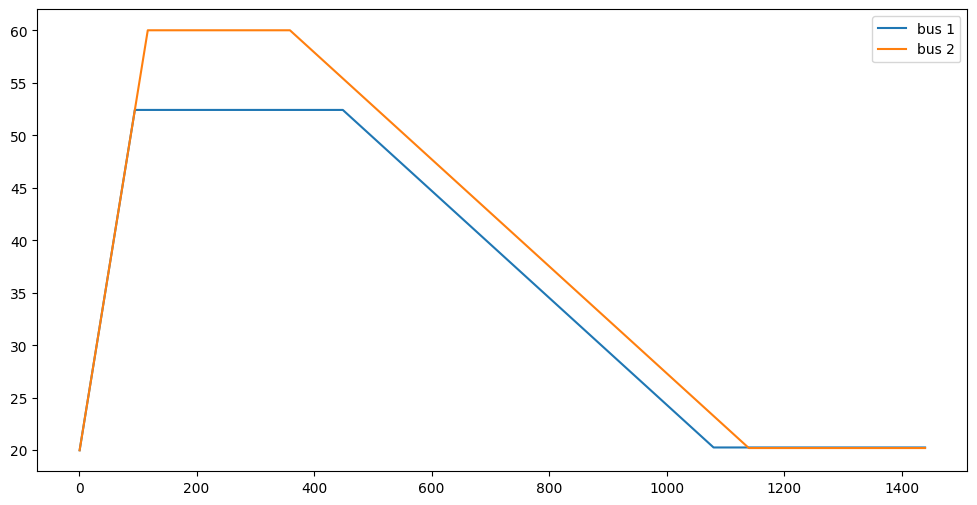

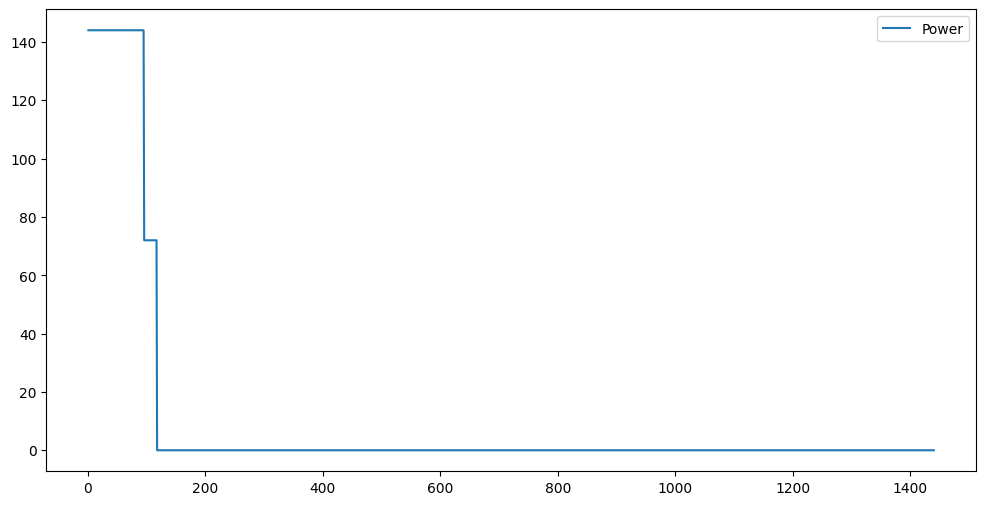

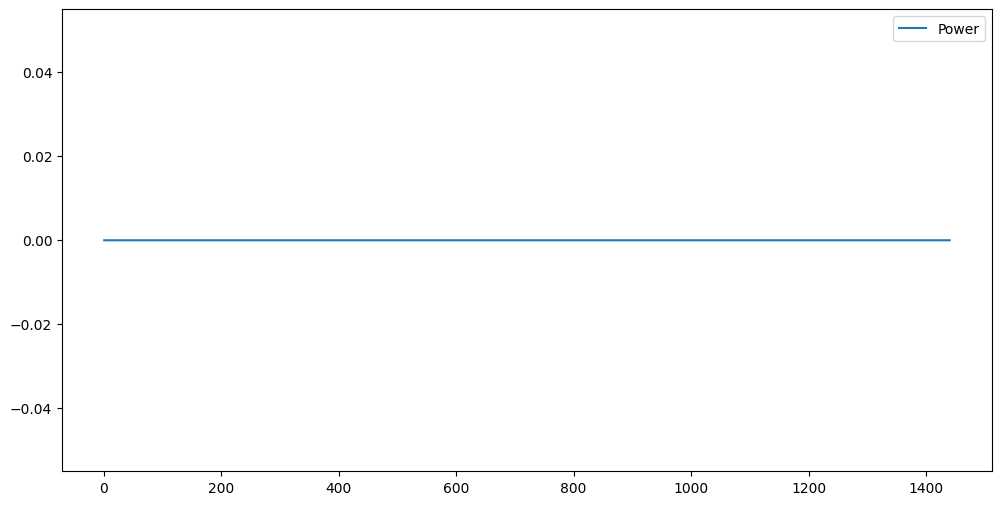

In [87]:
Energy = energy_bus(model.K,model.T,model.e)
Energy_perc = (Energy*100)/C_bat[0]
Energy_perc.plot(figsize=(12,6))
Energy_perc.describe()

W_buy = power(model.T,model.w_buy)*60
W_buy.plot(figsize=(12,6))
W_buy.describe()

W_sell = power(model.T,model.w_sell)*60
W_sell.plot(figsize=(12,6))
W_sell.describe()

Degradation = degradation(model.K,model.T,model.d)

In [88]:
with pd.ExcelWriter('../Results/output_deterministic.xlsx') as writer:  
    Energy.to_excel(writer, sheet_name='Energy')
    W_buy.to_excel(writer, sheet_name='Power (Buy)')
    W_sell.to_excel(writer, sheet_name='Power (Sell)')
    Degradation.to_excel(writer, sheet_name='Battery Degradation')